In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

import gym
import tensorflow as tf 
import numpy as np 
import random
from collections import deque
# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

In [2]:
# Hyper Parameters for DQN
GAMMA = 0.9 # discount factor for target Q 
INITIAL_EPSILON = 0.5 # starting value of epsilon
FINAL_EPSILON = 0.01 # final value of epsilon
REPLAY_SIZE = 10000 # experience replay buffer size
BATCH_SIZE = 32 # size of minibatch

# ---------------------------------------------------------
# Hyper Parameters for training
ENV_NAME = 'CartPole-v0'
EPISODE = 10000 # Episode limitation
STEP = 300 # Step limitation in an episode
TEST = 10 # The number of experiment test every 100 episode

In [3]:
class DQN():
    # DQN Agent
    def __init__(self, env):
        # init experience replay
        self.replay_buffer = deque()
        # init some parameters
        self.time_step = 0
        self.epsilon = INITIAL_EPSILON
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n 

        self.create_Q_network()
        self.create_training_method()

        # Init session
        self.session = tf.InteractiveSession()
        self.session.run(tf.initialize_all_variables())

        # loading networks
        self.saver = tf.train.Saver()
        checkpoint = tf.train.get_checkpoint_state("saved_networks")
        if checkpoint and checkpoint.model_checkpoint_path:
                self.saver.restore(self.session, checkpoint.model_checkpoint_path)
                print "Successfully loaded:", checkpoint.model_checkpoint_path
        else:
                print "Could not find old network weights"

        global summary_writer
        summary_writer = tf.train.SummaryWriter('~/logs',graph=self.session.graph)

    def create_Q_network(self):
        # network weights
        W1 = self.weight_variable([self.state_dim,20])
        b1 = self.bias_variable([20])
        W2 = self.weight_variable([20,self.action_dim])
        b2 = self.bias_variable([self.action_dim])
        # input layer
        self.state_input = tf.placeholder("float",[None,self.state_dim])
        # hidden layers
        h_layer = tf.nn.relu(tf.matmul(self.state_input,W1) + b1)
        # Q Value layer
        self.Q_value = tf.matmul(h_layer,W2) + b2


    def create_training_method(self):
        self.action_input = tf.placeholder("float",[None,self.action_dim]) # one hot presentation
        self.y_input = tf.placeholder("float",[None])
        Q_action = tf.reduce_sum(tf.mul(self.Q_value,self.action_input),reduction_indices = 1)
        self.cost = tf.reduce_mean(tf.square(self.y_input - Q_action))
        tf.scalar_summary("loss",self.cost)
        global merged_summary_op
        merged_summary_op = tf.merge_all_summaries()
        self.optimizer = tf.train.AdamOptimizer(0.0001).minimize(self.cost)

    def perceive(self,state,action,reward,next_state,done):
        one_hot_action = np.zeros(self.action_dim)
        one_hot_action[action] = 1
        self.replay_buffer.append((state,one_hot_action,reward,next_state,done))
        if len(self.replay_buffer) > REPLAY_SIZE:
            self.replay_buffer.popleft()

        if len(self.replay_buffer) > BATCH_SIZE:
            self.train_Q_network()

    def train_Q_network(self):
        self.time_step += 1
        # Step 1: obtain random minibatch from replay memory
        minibatch = random.sample(self.replay_buffer,BATCH_SIZE)
        state_batch = [data[0] for data in minibatch]
        action_batch = [data[1] for data in minibatch]
        reward_batch = [data[2] for data in minibatch]
        next_state_batch = [data[3] for data in minibatch]

        # Step 2: calculate y
        y_batch = []
        Q_value_batch = self.Q_value.eval(feed_dict={self.state_input:next_state_batch})
        for i in range(0,BATCH_SIZE):
            done = minibatch[i][4]
            if done:
                y_batch.append(reward_batch[i])
            else :
                y_batch.append(reward_batch[i] + GAMMA * np.max(Q_value_batch[i]))

        self.optimizer.run(feed_dict={
            self.y_input:y_batch,
            self.action_input:action_batch,
            self.state_input:state_batch
            })
        summary_str = self.session.run(merged_summary_op,feed_dict={
                self.y_input : y_batch,
                self.action_input : action_batch,
                self.state_input : state_batch
                })
        summary_writer.add_summary(summary_str,self.time_step)

        # save network every 1000 iteration
        if self.time_step % 1000 == 0:
            self.saver.save(self.session, 'saved_networks/' + 'network' + '-dqn', global_step = self.time_step)

    def egreedy_action(self,state):
        Q_value = self.Q_value.eval(feed_dict = {
            self.state_input:[state]
            })[0]
        if random.random() <= self.epsilon:
            return random.randint(0,self.action_dim - 1)
        else:
            return np.argmax(Q_value)

        self.epsilon -= (INITIAL_EPSILON - FINAL_EPSILON)/10000

    def action(self,state):
        return np.argmax(self.Q_value.eval(feed_dict = {
            self.state_input:[state]
            })[0])

    def weight_variable(self,shape):
        initial = tf.truncated_normal(shape)
        return tf.Variable(initial)

    def bias_variable(self,shape):
        initial = tf.constant(0.01, shape = shape)
        return tf.Variable(initial)

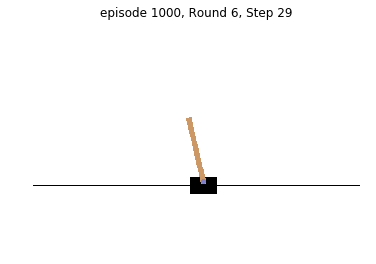

In [ ]:
# TRAINING AND TESTING

# initialize OpenAI Gym env and dqn agent
env = gym.make(ENV_NAME)
agent = DQN(env)

for episode in xrange(EPISODE):
    # initialize task
    state = env.reset()
    # Train 
    for step in xrange(STEP):
        action = agent.egreedy_action(state) # e-greedy action for train
        next_state,reward,done,_ = env.step(action)
        # Define reward for agent
        reward_agent = -1 if done else 0.1
        agent.perceive(state,action,reward,next_state,done)
        state = next_state
        if done:
            break
    # Test every 100 episodes
    if episode % 100 == 0:
        total_reward = 0
        for i in xrange(TEST):
            state = env.reset()
            for j in xrange(STEP):
                env.render()
                action = agent.action(state) # direct action for test
                state,reward,done,_ = env.step(action)
                total_reward += reward
                plt.figure(3)
                plt.clf()
                plt.imshow(env.render(mode='rgb_array'))
                plt.title("episode %d, Round %d, Step %d" % (episode, i, j))
                plt.axis('off')

                display.clear_output(wait=True)
                display.display(plt.gcf())
                if done:
                    break
        ave_reward = total_reward/TEST
        print 'episode: ',episode,'Evaluation Average Reward:',ave_reward
        if ave_reward >= 200:
            break

In [ ]:
# save results for uploading
# env = gym.wrappers.Monitor(env, 'gym_results/CartPole-v0-experiment-1', force=True)
for i in xrange(100):
    state = env.reset()
    for j in xrange(200):
        env.render()
        action = agent.action(state) # direct action for test
        state,reward,done,_ = env.step(action)
        total_reward += reward
        
        plt.figure(3)
        plt.clf()
        plt.imshow(env.render(mode='rgb_array'))
        plt.title("Round %d: Step: %d" % (i, j))
        plt.axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
        if done:
            break

In [ ]:
# save results for uploading
env = gym.wrappers.Monitor(env, 'gym_results/CartPole-v0-experiment-1', force=True)
for i in xrange(100):
    state = env.reset()
    for j in xrange(200):
        env.render()
        action = agent.action(state) # direct action for test
        state,reward,done,_ = env.step(action)
        total_reward += reward
        if done:
            break